In [1]:
# Libraries
library(ggraph)
library(ggpubr)
library(igraph)
library(tidyverse)
library(RColorBrewer)
library(repr)

Loading required package: ggplot2


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::groups()        masks igraph::groups()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::simplify()      masks igraph::simplify()



#### Loading data

In [2]:
args <- 0

sessions = c("141017", "141014", "141015", "141016", "141023", "141024", "141029",
             "141103", "141112", "141113", "141125", "141126", "141127", "141128",
             "141202", "141203", "141205", "141208", "141209", "141211", "141212",
             "141215", "141216", "141217", "141218", "150114", "150126", "150128",
             "150129", "150205", "150210", "150211", "150212", "150213", "150217",
             "150219", "150223", "150224", "150226", "150227", "150302", "150303",
             "150304", "150305", "150403", "150407", "150408", "150413", "150414",
             "150415", "150416", "150427", "150428", "150429", "150430", "150504",
             "150511", "150512", "150527", "150528", "150529", "150608")
session <- sessions[as.integer(args[1])] 
session <- "141017"

# Path to save figures
results <- "/home/vinicius/storage1/projects/GrayData-Analysis/figures/nli/"
# Root path to read the data
ROOT <- "/home/vinicius/funcog/gda/Results/lucy/nli/"

In [3]:
# Function to return file name
get_nli_file_name <- function(s_idx) {
  FILE_NAME <- paste(
    c(ROOT, "nli_coh_", sessions[s_idx], ".csv"),
    collapse = "")
  return(FILE_NAME)
}

get_pow_file_name <- function(s_idx) {
  FILE_NAME <-   paste(
    c(ROOT, "mean_power_coh_",
      session, ".csv"),
    collapse="")
  return(FILE_NAME)
}

read_data_nli <- function(file_name) {
  out <- read.csv(file_name)
  out$X <- NULL
  out$s <- NULL
  out$t <- NULL 
  return(out)
}

read_data_pow <- function(file_name) {
  out <- read.csv(file_name)
  out$X <- NULL
  return(out)
}

load_df <- function(which) {
  if(which == "nli") {
    get_file_name <- get_nli_file_name
    read_data <- read_data_nli
  } else if (which == "power") {
    get_file_name <- get_pow_file_name
    read_data <- read_data_pow   
  }
  df <- NULL
  for(s_idx in 1:length(sessions)) {
    file_name <- get_file_name(s_idx)
    if(file.exists(file_name)) {
      if(is.null(df)) {
        df <- read_data(file_name)
      } else {
        df <- rbind(df, read_data(file_name))
      }
    }
  }
  return(df)
}

In [4]:
nli <- load_df("nli")
power <- load_df("power")

nli <- nli %>% group_by(roi_s, roi_t, f) %>% 
  summarise(nli = mean(nli), coh_st = mean(coh_st))

power <- power %>% group_by(roi, freqs) %>%
  summarise(power = mean(power))

# Get frequencies
freqs <- unique(nli$f)

`summarise()` has grouped output by 'roi_s', 'roi_t'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'roi'. You can override using the `.groups` argument.


#### Create igraph object

In [5]:
create_graph <- function(f, metric) {
  # Get freqs of interest
  idx <- (nli$f == f) 
  # Filter data-frame
  df <- nli[idx, ]
  # Filter power
  idx_p <- (power$freqs == f)
  p_filt <- power[idx_p, ]
  
  # Creating network
  edges <- df %>% select(roi_s, roi_t, metric)
  colnames(edges) <- c("from", "to", "weights")
  
  #edges <- edges[order(edges$weights),]
  edges <- edges[order(df$nli),]
  
  rois <- unique(c(as.character(edges$from), as.character(edges$to)))
  n_rois <- length(rois)
  n_pairs <- length(weights)
  
  nodes <- as.data.frame(rois)
  nodes <- nodes %>% rename(id = rois)
  
  # Create a graph object
  graph <- igraph::graph_from_data_frame( d=edges, vertices=nodes, directed=F )
  strengths <- igraph::strength(graph = graph, weights = edges$weights)
  
  # Getting power for each ROI
  node_size <- rep(0, length(rois))
  i <- 1
  for(roi in rois) {
    if(roi %in% p_filt$roi) {
      node_size[i] <- p_filt[p_filt$roi==roi, ]$power
    } else {
      node_size[i] <- 0
    }
    i <- i + 1
  }
  
  if(metric == "nli") {
    high <- "blue"
    limits <- c(0, max(edges$weights))
  } else {
    high <- "red"
    limits <- c(0, max(edges$weights))
  }
  
  node_size <- 
    5 * (node_size - min(node_size)) / (max(node_size) + min(node_size))
  
  filter <- (edges$weights>0)
  p <- ggraph(graph, layout = 'linear', circular = TRUE) + 
    geom_edge_arc(aes(filter=filter, width=edges$weights,
                      color=edges$weights),
                  show.legend=F) +
    scale_edge_color_continuous(low = "white", high = high,
                                na.value=high, limits=limits) +
    scale_edge_width_continuous(range = c(0, 3)) +
    geom_node_point(aes(x = x*1.07, y=y*1.07),
                    color="orange",
                    size=node_size,
                    show.legend=F,
                    alpha=0.6) +
    geom_node_text(aes(label=rois, x=x*1.15, y=y*1.15), color="black",
                   size=2, alpha=1, show.legend=F) +
    theme_void() +
    ggtitle(paste(c(f, " Hz"), collapse = "")) +
    theme(
      plot.title = element_text(hjust = 0.5, size=10),
      plot.margin=unit(c(0,0,0,0),"cm"),
    )
  p
  return(p)
}

#### NLI

In [ ]:
myplots <- vector('list', length(freqs))
i<-1
for(f in freqs) {
  p1 <- create_graph(f, "nli")
  myplots[[i]] <- local({
    i <- i
    print(p1)
  })
  i <- i + 1
}

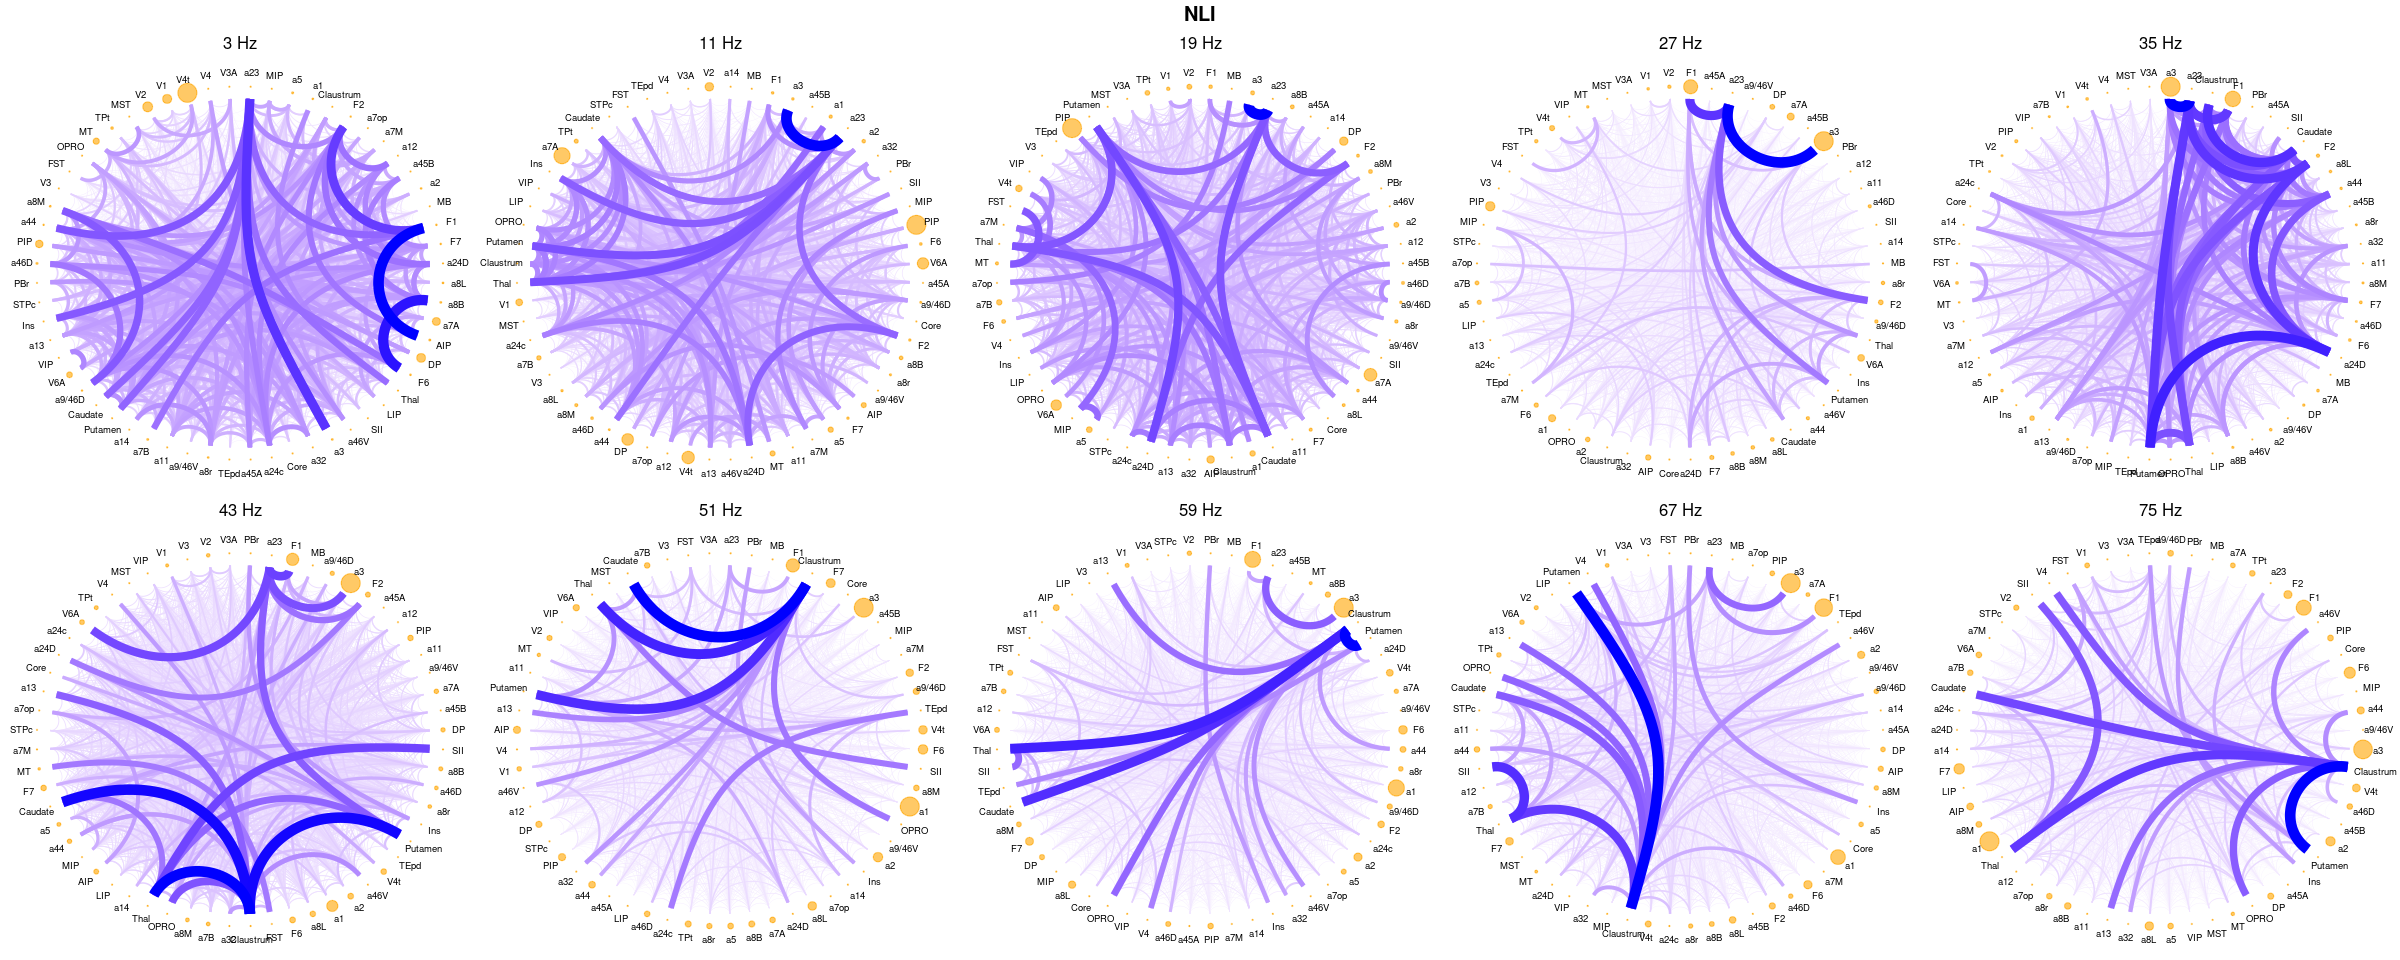

In [7]:
options(repr.plot.width=20, repr.plot.height=8)
plot <- ggarrange(plotlist=myplots,
                  ncol = length(freqs) / 2, nrow = 2) 
annotate_figure(plot, top = text_grob("NLI", 
                                      color = "black",
                                      face = "bold", size = 12))
ggsave(
  paste(
    c(results,
      "nli_plot.png"),
    collapse = ""),
  width = 18, height = 6)

#### Plot mean coherence

In [ ]:
myplots <- vector('list', length(freqs))
i<-1
for(f in freqs) {
  p1 <- create_graph(f, "coh_st")
  myplots[[i]] <- local({
    i <- i
    print(p1)
  })
  i <- i + 1
}

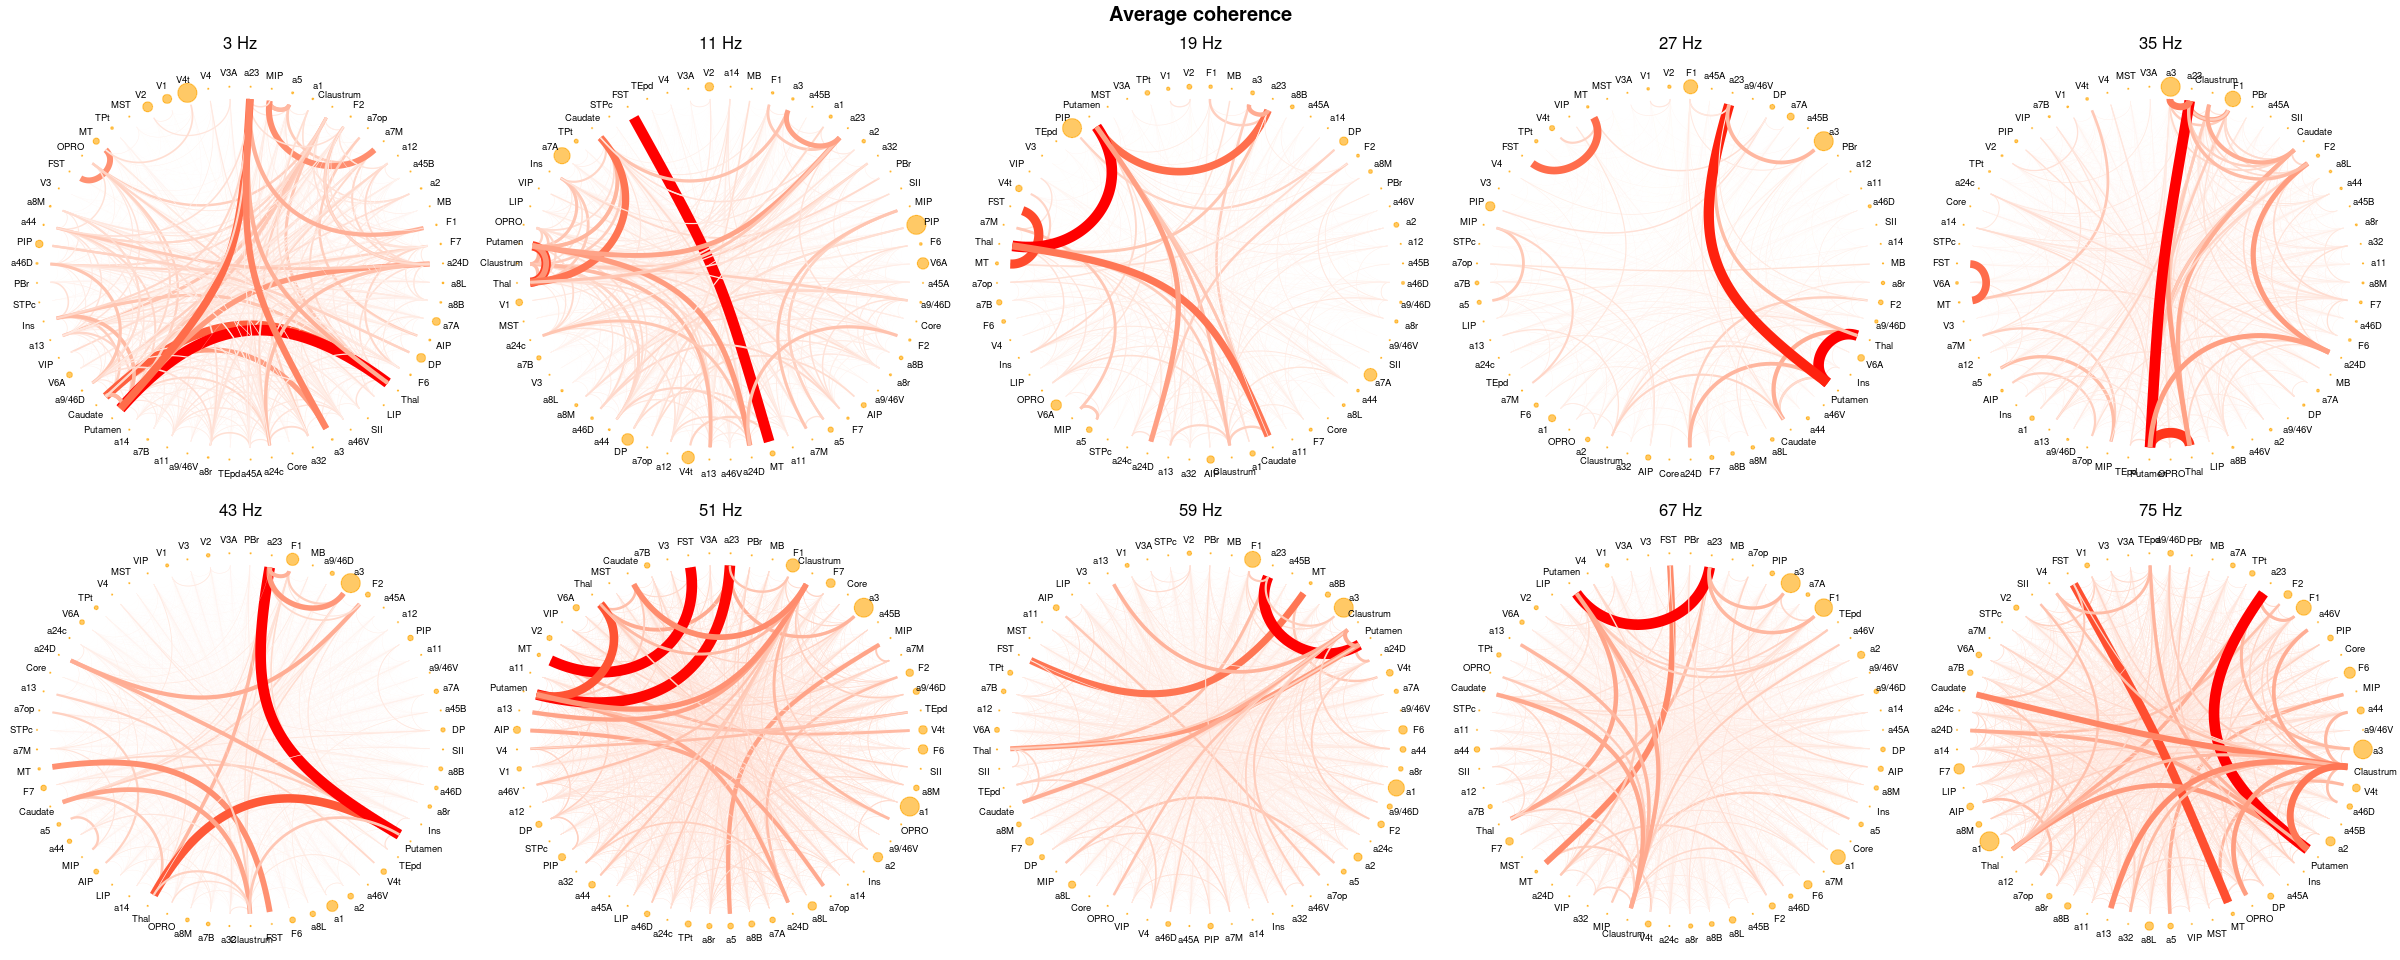

In [9]:
options(repr.plot.width=20, repr.plot.height=8)
plot <- ggarrange(plotlist=myplots,
                  ncol = length(freqs) / 2, nrow = 2) 
annotate_figure(plot, top = text_grob("Average coherence", 
                                      color = "black",
                                      face = "bold", size = 12))
ggsave(
  paste(
    c(results,
      "coh_plot.png"),
    collapse = ""),
  width = 18, height = 6)